In [1]:
import os
import pandas as pd
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dropout

# constants

In [2]:
DATASET_DIR = "dataset/"
TRAIN_DIR = os.path.join(DATASET_DIR, "training/")
#TEST_DIR = os.path.join(DATASET_DIR, "asl_alphabet_test/asl_alphabet_test")

IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

CLASSES = os.listdir(TRAIN_DIR)
NUM_CLASSES = len(CLASSES)

SEED = 17

# Load Data

In [3]:
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 7800 files belonging to 26 classes.
Using 6240 files for training.
Found 7800 files belonging to 26 classes.
Using 1560 files for validation.


# Visualize

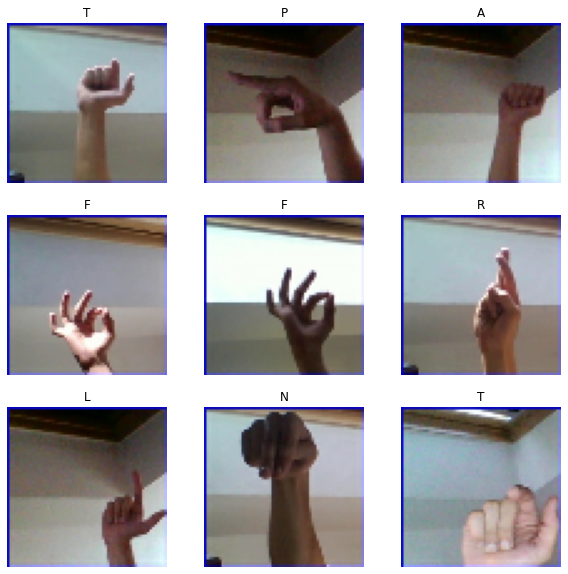

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

# Normalize Image

In [5]:
normalize = Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalize(x), y))
val_ds = val_ds.map(lambda x, y: (normalize(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Define the CNN Achitecture

In [6]:
inputs = Input(shape=IMAGE_SIZE+(3,), batch_size=BATCH_SIZE)

# Convolutional Base
x = Conv2D(64, kernel_size=3, padding="same", activation="relu")(inputs)
x = MaxPooling2D(2)(x)

x = Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)

x = Conv2D(256, kernel_size=3, padding="same", activation="relu")(x)
x = MaxPooling2D(2)(x)

# Head (Classifier)
x = Flatten()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=x, name="ASL_CNN")

In [7]:
model.summary()

Model: "ASL_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 64, 64, 3)]         0         
                                                                 
 conv2d (Conv2D)             (32, 64, 64, 64)          1792      
                                                                 
 max_pooling2d (MaxPooling2D  (32, 32, 32, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 32, 32, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 16, 16, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 16, 16, 256)         2951

# Compile The Model

In [8]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train The Model

In [10]:
epochs = 25

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Epoch 1/25
195/195 [==============================] - 108s 544ms/step - loss: 3.1850 - accuracy: 0.0744 - val_loss: 2.7453 - val_accuracy: 0.2047
Epoch 2/25
195/195 [==============================] - 110s 563ms/step - loss: 2.3587 - accuracy: 0.2729 - val_loss: 1.6044 - val_accuracy: 0.5121
Epoch 3/25
195/195 [==============================] - 104s 531ms/step - loss: 1.5253 - accuracy: 0.4994 - val_loss: 1.0125 - val_accuracy: 0.6932
Epoch 4/25
195/195 [==============================] - 108s 554ms/step - loss: 1.1025 - accuracy: 0.6176 - val_loss: 0.6368 - val_accuracy: 0.8055
Epoch 5/25
195/195 [==============================] - 104s 534ms/step - loss: 0.8172 - accuracy: 0.7133 - val_loss: 0.5370 - val_accuracy: 0.8348
Epoch 6/25
195/195 [==============================] - 105s 536ms/step - loss: 0.6733 - accuracy: 0.7647 - val_loss: 0.4448 - val_accuracy: 0.8431
Epoch 7/25
195/195 [==============================] - 106s 543ms/step - loss: 0.5507 - accuracy: 0.8027 - val_loss: 0.4124 -

<AxesSubplot:>

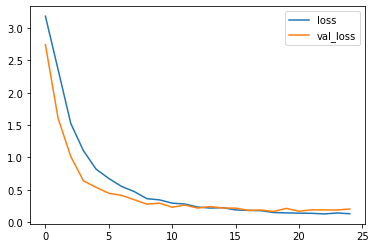

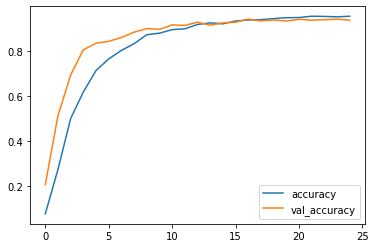

In [11]:
df = pd.DataFrame(history.history)
df.loc[:, ["loss", "val_loss"]].plot()
df.loc[:, ["accuracy", "val_accuracy"]].plot()

# df.loc[:, ["accuracy", "loss"]].plot()
# df.loc[:, ["val_accuracy", "val_loss"]].plot()

In [23]:
# # model.save('model_sibi_fix.h5')

model.save("cnn_model_25b.hdf5")
print("Model Saved")

Model Saved


In [13]:
# model_json=model.to_json()
# with open("model.json", "w") as file:
#     file.write(model_json)
# model.save_weights("model.h5")
# print("SUCCES model is SAVED !")

In [14]:
# from keras.models import model_from_json
# json_file = open('model.json','r')
# loaded_model_json = json_file.read()
# json_file.close()

# load_model = model_from_json(loaded_model_json)
# load_model.load_weights("model.h5")
# print("LOADED!")

In [15]:
# import cv2
# from keras.preprocessing.image import ImageDataGenerator

# image = cv2.imread("dataset/training/D/D1.jpg")
# image = cv2.resize(image,IMAGE_SIZE)
# image = np.reshape(image,[1,64,64,3])
# prediksi = load_model.predict(image)
# #prediksi = model.predict_classes(image)
# print("Prediksinya adalah huruf ",prediksi)

In [16]:

import cv2
from keras.preprocessing.image import ImageDataGenerator

test_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = test_generator.flow_from_directory(
    'dataset/test/',
    target_size=(64,64),
    batch_size=32,
#     seed=SEED,
    shuffle=False
)

Found 1560 images belonging to 26 classes.


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

prediksi = model.predict_generator(test_data_generator)
y_pred = np.argmax(prediksi, axis=1)

print("==============================Confusion Matrix==============================")
print(confusion_matrix(test_data_generator.classes, y_pred))


C:\Users\M Fikri Setiawan\AppData\Local\Temp\ipykernel_18524\3862568218.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediksi = model.predict_generator(test_data_generator)


==============================Confusion Matrix==============================
[[58  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
   0  0]
 [ 0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 59  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 2  1  0  0 57  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1  0  0 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  1 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  1

In [24]:
print("==============================Hasil==============================")
print(classification_report(test_data_generator.classes, y_pred))

==============================Hasil==============================
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.98      1.00      0.99        60
           2       0.97      0.98      0.98        60
           3       0.98      1.00      0.99        60
           4       0.97      0.95      0.96        60
           5       1.00      0.98      0.99        60
           6       1.00      1.00      1.00        60
           7       1.00      1.00      1.00        60
           8       0.98      1.00      0.99        60
           9       1.00      0.98      0.99        60
          10       1.00      1.00      1.00        60
          11       1.00      0.98      0.99        60
          12       1.00      0.88      0.94        60
          13       0.89      0.98      0.94        60
          14       1.00      0.97      0.98        60
          15       0.97      0.98      0.98        60
          16   

In [19]:
import string

labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


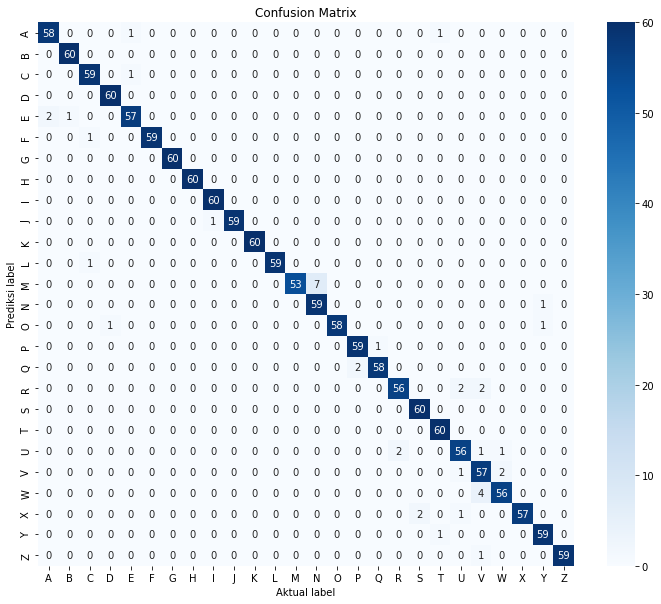

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 
                        'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']) 
predicted_labels = np.array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 
                             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']) 

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 
               'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] 

cm_df = pd.DataFrame(confusion_matrix(test_data_generator.classes, y_pred), index=class_names, columns=class_names)

f, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cm_df, annot=True, fmt=".0f", ax=ax, cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel("Aktual label")
plt.ylabel("Prediksi label")
plt.show()

In [ ]:
58/(58+2) =

In [21]:
# import tensorflow as tf
# import os
# import pandas as pd
# import numpy as np
# import math
# import tensorflow as tf
# print(tf.__version__)
# print(pd.__version__)
# print(np.__version__)